# eCLIP-Seq differential binding analysis in Mouse AML12

In [1]:
library(dplyr)
library(reshape2)
library(tidyverse)
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(ggplotify)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGe

In [2]:
depth.mat <- read.table(file = 'data/depth.mat.csv',header = TRUE,sep = ',',row.names = 1) %>% as.matrix


In [3]:
coldata <- read.table(file = 'data/coldata.csv',header = TRUE,sep = ',',row.names = 1)


In [4]:
dds.peaks <- depth.mat %>% 
DESeqDataSetFromMatrix(
    colData = coldata,
    design = ~Biorep+Pulldown+Condition
) %>% 
estimateSizeFactors %>% estimateDispersions


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [5]:
dds.peaks.input <- dds.peaks[,dds.peaks@colData$Pulldown == 'Input']


In [6]:
dds.peaks.input <- dds.peaks.input %>% estimateSizeFactors


In [7]:
dds.subcontrol.eclip.normalisedByInput <- dds.peaks %>% counts %>% 
(function(.) {
    subctrl <- .[,dds.peaks@colData %>% data.frame %>% arrange(Pulldown,Condition,Biorep) %>% filter(Pulldown == 'eCLIP') %>% row.names] - .[,dds.peaks@colData %>% data.frame %>% arrange(Pulldown,Condition,Biorep) %>% filter(Pulldown == 'Input') %>% row.names]
    
    subctrl[subctrl<0] <- 0
    subctrl %>% 
    DESeqDataSetFromMatrix(
        colData = dds.peaks@colData %>% data.frame %>% arrange(Pulldown,Condition,Biorep) %>% filter(Pulldown == 'eCLIP'),
        design = ~Biorep + Condition
    )
})


converting counts to integer mode



In [8]:
dds.subcontrol.eclip.normalisedByInput@colData$sizeFactor <- dds.peaks.input@colData %>% data.frame %>% arrange(Pulldown,Condition,Biorep) %>% filter(Pulldown == 'Input') %>% with(sizeFactor)


In [9]:
dds.subcontrol.eclip.normalisedByInput <- dds.subcontrol.eclip.normalisedByInput %>% estimateDispersions


gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates



In [10]:
dds.subcontrol.eclip.normalisedByInput.nbinomwaldtest <- dds.subcontrol.eclip.normalisedByInput %>% nbinomWaldTest


In [11]:
ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest <- dds.subcontrol.eclip.normalisedByInput.nbinomwaldtest %>% 
results(contrast = c('Condition','J2.AR1KO','J2.WT'))


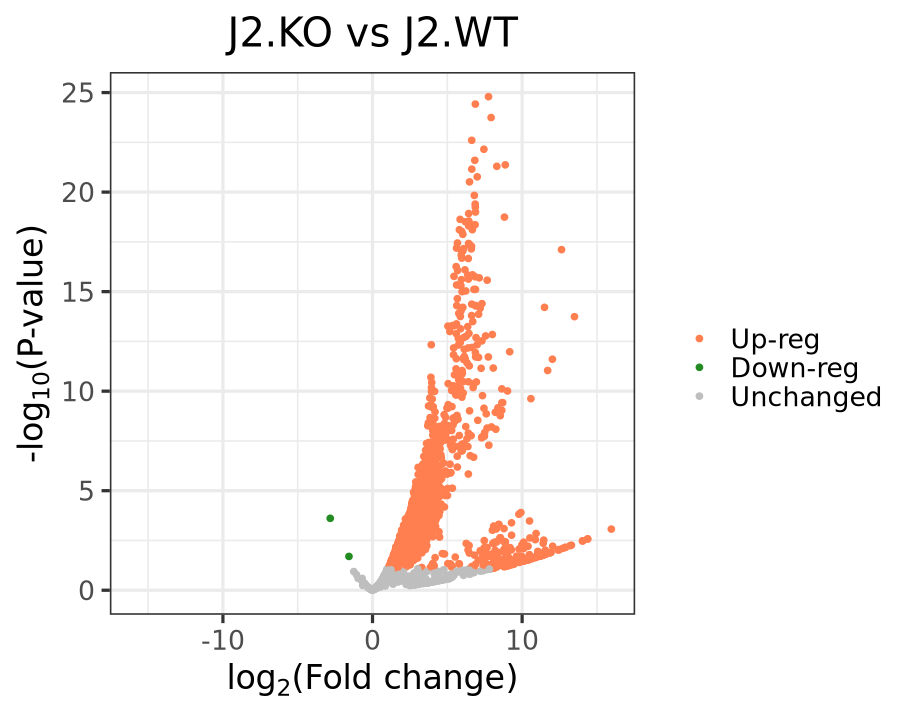

In [12]:
options(repr.plot.width = 7.5,repr.plot.height = 6)

g <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest %>% data.frame %>% 
filter(baseMean >= 10) %>% 

(function(.) ggplot(.,mapping = aes(
    x = log2FoldChange,y = -log10(pvalue),
    col = case_when(
        log2FoldChange > 1 & padj < .05 ~ 'Up-reg',
        log2FoldChange < -1 & padj < .05 ~ 'Down-reg',
        .default = 'Unchanged'
    ) %>% factor(levels = c('Up-reg','Down-reg','Unchanged'))
)) +
#scale_color_manual(name = '',values = c('Up-reg' = 'firebrick','Down-reg' = 'forestgreen','Unchanged' = 'gray')) +
scale_color_manual(
    name='',
    values = c('Up-reg'='coral','Down-reg'='forestgreen','Unchanged'='gray'),
    breaks=c('Up-reg','Down-reg','Unchanged')
) +
geom_point() +

coord_cartesian(xlim = c(-with(.,log2FoldChange %>% abs %>% max),with(.,log2FoldChange %>% abs %>% max))) +
labs(title = 'J2.KO vs J2.WT',x = expression('log'[2]*'(Fold change)'),y = expression('-log'[10]*'(P-value)')) +
theme_bw(base_size = 20) +
theme(plot.title = element_text(hjust = .5))
)

g


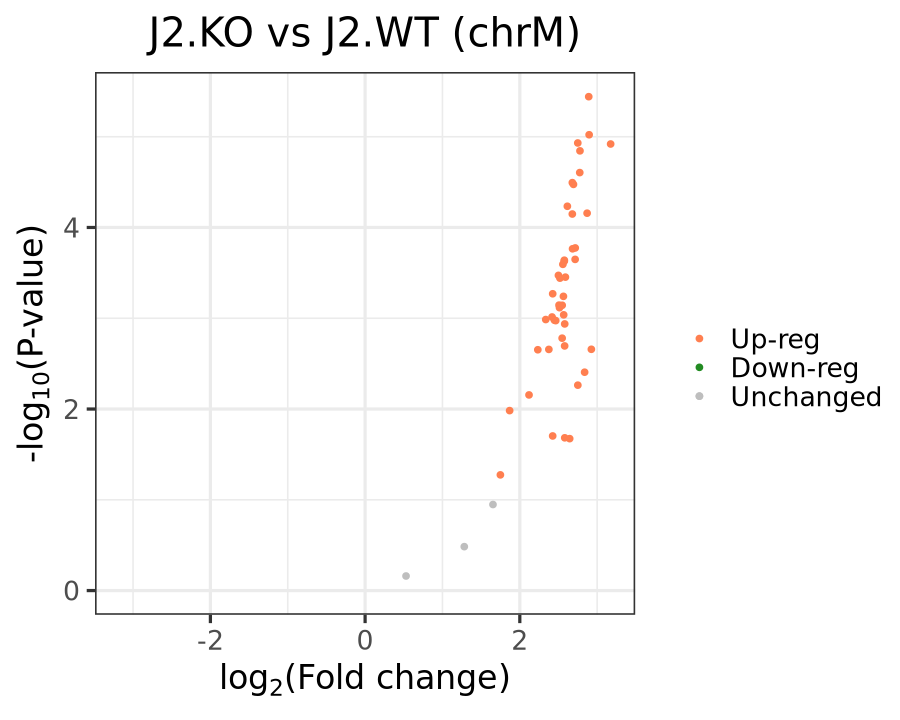

In [13]:
g <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest %>% data.frame %>% 
filter(baseMean >= 10) %>% 
rownames_to_column('Name') %>% 
mutate(
    Chr = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\1',Name),
    Start = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\2',Name),
    End = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\2',Name),
    .before = 1
) %>% 
mutate(
    Strand = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\4',Name),
    .after = "Name"
) %>% 
filter(Chr=='chrM') %>% 

(function(.) ggplot(.,mapping = aes(
    x = log2FoldChange,y = -log10(pvalue),
    col = case_when(
        log2FoldChange > 1 & padj < .05 ~ 'Up-reg',
        log2FoldChange < -1 & padj < .05 ~ 'Down-reg',
        .default = 'Unchanged'
    ) %>% factor(levels = c('Up-reg','Down-reg','Unchanged'))
)) +
geom_point(data = filter(.,Chr == 'chrM')) +
#scale_color_manual(name = '',values = c('Up-reg' = 'firebrick','Down-reg' = 'forestgreen','Unchanged' = 'gray')) +
scale_color_manual(
    name='',
    values = c('Up-reg'='coral','Down-reg'='forestgreen','Unchanged'='gray'),
    breaks=c('Up-reg','Down-reg','Unchanged'),
    drop = FALSE
) +

coord_cartesian(xlim = c(-with(.,log2FoldChange %>% abs %>% max),with(.,log2FoldChange %>% abs %>% max))) +
labs(title = 'J2.KO vs J2.WT (chrM)',x = expression('log'[2]*'(Fold change)'),y = expression('-log'[10]*'(P-value)')) +
guides(color=guide_legend(override.aes = c(alpha=1))) +
theme_bw(base_size = 20) +
theme(plot.title = element_text(hjust = .5))
)

g


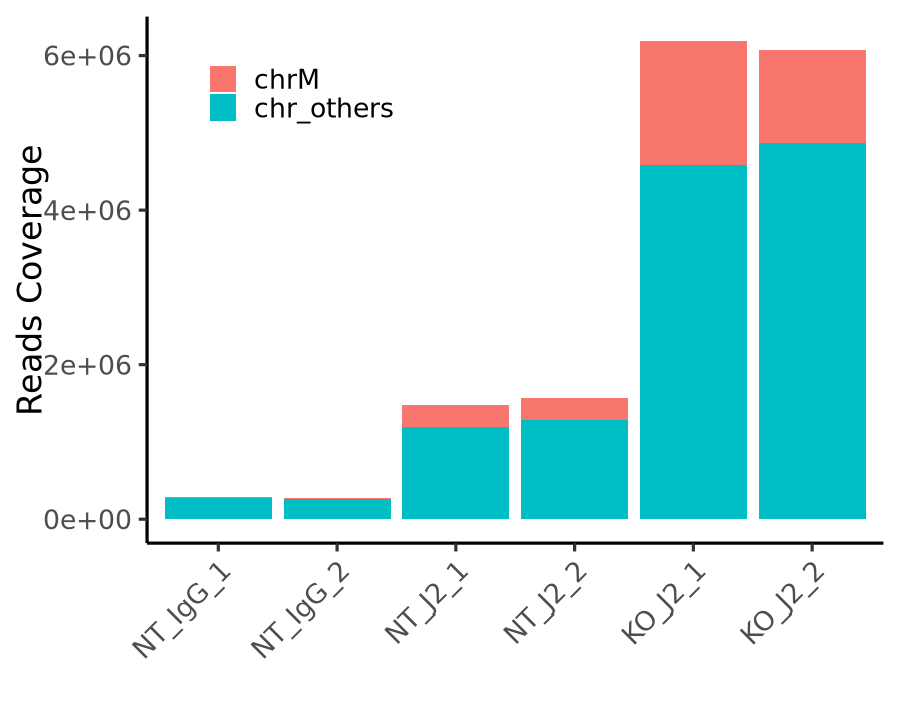

In [14]:
options(repr.plot.width = 7.5,repr.plot.height = 6,scipen = 1)

g <- dds.peaks.eCLIP %>% counts(normalized = FALSE) %>% 
melt %>% 
mutate(chrM = ifelse(grepl('^chrM',Var1 %>% as.character),'chrM','chr_others') %>% factor(levels = c('chrM','chr_others'))) %>% 
group_by(Var2,chrM) %>% 
reframe(cov.sum = value %>% sum) %>% 
group_by(Var2) %>% 
mutate(cov.sum.fraction = cov.sum/(cov.sum %>% sum)) %>% 
mutate(coldata[Var2 %>% as.character,],.after = 1) %>% 
mutate(Var2 = gsub('count\\.eCLIP_','',Var2) %>% factor(levels = c('WT_IgG_1','WT_IgG_2','WT_J2_1','WT_J2_2','AR1KO_J2_1','AR1KO_J2_2'),
                                                        labels = c('NT_IgG_1','NT_IgG_2','NT_J2_1','NT_J2_2','KO_J2_1','KO_J2_2'))) %>% 

ggplot(mapping = aes(
    x = Var2,y = cov.sum,fill = chrM
)) +
geom_bar(stat = 'identity') +
scale_fill_discrete(name = '') +

labs(x = '',y = 'Reads Coverage') +
theme_classic(base_size = 20) +
theme(legend.position = 'inside',legend.position.inside = c(.2,.9),axis.text.x = element_text(angle = 45,hjust = 1,vjust = 1))

g


In [15]:
peaks_concat_merged_anno.txt <- read.table(file = 'data/peaks_concat_merged_anno.txt',header = TRUE,sep ='\t',quote = '',comment.char = '')


In [16]:
ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest %>% data.frame %>% 
filter(baseMean >= 10) %>% 
rownames_to_column('Name') %>% 
mutate(
    Chr = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\1',Name) %>% factor(levels = paste0('chr',c(1:19,'X','M'))),
    Start = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\2',Name),
    End = sub('(chr[0-9XYMT]*)_([0-9]*)_([0-9]*)_([+-])','\\2',Name),
    .before = 1
) %>% 
 
mutate(
    (peaks_concat_merged_anno.txt %>% arrange(-log10p,-log2fc) %>% dplyr::select(-c('Name')) %>% 
    mutate(peakid = paste0(Chr,'_',Start,'_',End,'_',Strand)) %>% 
    column_to_rownames('peakid'))[Name,]
)
 

In [17]:
ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
mutate(
    rmsk = ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
    with(Detailed.Annotation) %>% 
    sapply(function(x) grep('intron|CDS|UTR|intergenic|TTS|TSS|exon|codon',x %>% strsplit(split=';') %>% unlist,value = TRUE,invert = TRUE) %>% paste(collapse = ';')),
    .after='Detailed.Annotation'
)


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


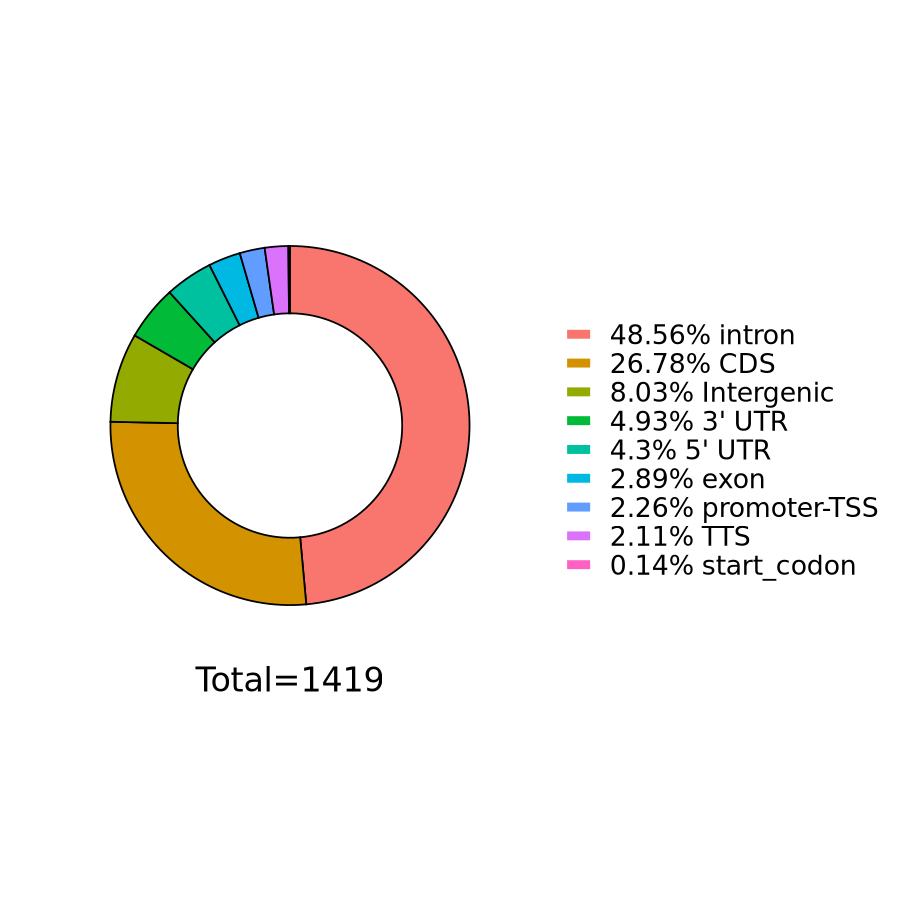

In [18]:
options(repr.plot.width = 7.5,repr.plot.height = 7.5)

g <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
filter(Chr!='chrM' & (log2FoldChange %>% abs) >= 1 & padj < .01) %>% 
filter((rmsk != '') | ((rmsk == '') & (log2FoldChange %>% abs) >= 2 & padj < 1e-3)) %>% 

mutate(Func.refGene = case_when(
    grepl('intergenic',Annotation) ~ 'Intergenic',
    .default = gsub(' .*','',Annotation)
)) %>% 
group_by(Func.refGene) %>% 
reframe(Func.refGene.count = Func.refGene %>% length) %>% 
arrange(-Func.refGene.count) %>% 
mutate(Func.refGene = gsub('UTR','\' UTR',Func.refGene)) %>% 
mutate(
    Func.refGene = Func.refGene %>% factor(
        levels = Func.refGene %>% as.character %>% unique
    )
) %>% 
mutate(ymax = Func.refGene.count %>% cumsum) %>% 
mutate(ymin = c(0,head(ymax,n = -1))) %>% 

(function(.) ggplot(.,mapping = aes(
    xmin = 2.5,xmax = 4,ymin = ymin,ymax = ymax,fill = Func.refGene
)) +
geom_rect(col = 'black') +
geom_line(mapping=aes(x=0,y=0,col = Func.refGene,group = Func.refGene),size = 2.5,alpha = 0) +
coord_polar(theta = "y", start=0) + xlim(c(0, 4)) +
scale_color_discrete(name = '',labels = with(.,paste0((100*Func.refGene.count/(Func.refGene.count %>% sum)) %>% round(digits = 2),'% ',Func.refGene))) +
scale_fill_discrete(guide='none',name = '',labels = with(.,paste0((100*Func.refGene.count/(Func.refGene.count %>% sum)) %>% round(digits = 2),'% ',Func.refGene))) +

labs(x = '',y = paste0('Total=',with(.,Func.refGene.count %>% sum))) +
theme_minimal(base_size = 20) +
theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank()
) +
guides(color = guide_legend(reverse = FALSE,override.aes = c(alpha = 1))))

g


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


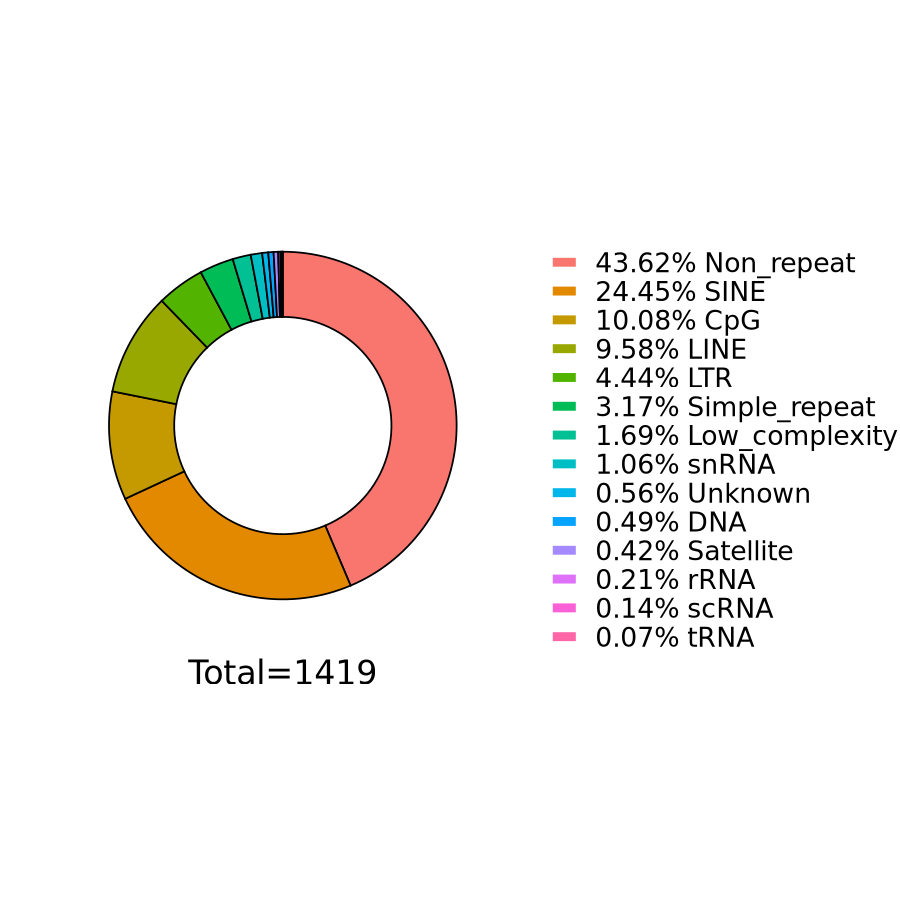

In [19]:
options(repr.plot.width = 7.5,repr.plot.height = 7.5)

g <- ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
filter(Chr!='chrM' & (log2FoldChange %>% abs) >= 1 & padj < .01) %>% 
filter((rmsk != '') | ((rmsk == '') & (log2FoldChange %>% abs) >= 2 & padj < 1e-3)) %>% 

filter(Chr!='chrM' & (log2FoldChange %>% abs) >= 1 & padj < .05) %>% 
mutate(rmsk = case_when(
    rmsk == '' ~ 'Non_repeat',
    grepl('SINE',rmsk) ~ 'SINE',
    grepl('CpG',rmsk) ~ 'CpG',
    grepl('Simple_repeat',rmsk) ~ 'Simple_repeat',
    .default = gsub('\\|.*','',rmsk)
)) %>% 
group_by(rmsk) %>% 
reframe(rmsk.count = rmsk %>% length) %>% 
arrange(-rmsk.count) %>% 
mutate(rmsk = gsub('UTR','\' UTR',rmsk)) %>% 
mutate(
    rmsk = rmsk %>% factor(
        levels = rmsk %>% as.character %>% unique
    )
) %>% 
mutate(ymax = rmsk.count %>% cumsum) %>% 
mutate(ymin = c(0,head(ymax,n = -1))) %>% 

(function(.) ggplot(.,mapping = aes(
    xmin = 2.5,xmax = 4,ymin = ymin,ymax = ymax,fill = rmsk
)) +
geom_rect(col = 'black') +
geom_line(mapping=aes(x=0,y=0,col = rmsk,group = rmsk),size = 2.5,alpha = 0) +
coord_polar(theta = "y", start=0) + xlim(c(0, 4)) +
scale_color_discrete(name = '',labels = with(.,paste0((100*rmsk.count/(rmsk.count %>% sum)) %>% round(digits = 2),'% ',rmsk))) +
scale_fill_discrete(guide='none',name = '',labels = with(.,paste0((100*rmsk.count/(rmsk.count %>% sum)) %>% round(digits = 2),'% ',rmsk))) +

labs(x = '',y = paste0('Total=',with(.,rmsk.count %>% sum))) +
theme_minimal(base_size = 20) +
theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank()
) +
guides(color = guide_legend(reverse = FALSE,override.aes = c(alpha = 1))))

g


In [20]:
dds.prior <- DESeqDataSetFromMatrix(
    countData = 10 + dds.peaks@assays@data$counts,
    colData = dds.peaks@colData %>% data.frame,
    design = dds.peaks@design
)

dds.prior@colData$sizeFactor <- rep(dds.peaks.input@colData$sizeFactor,times = 2)
dds.prior <- dds.prior %>% estimateDispersions


converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates



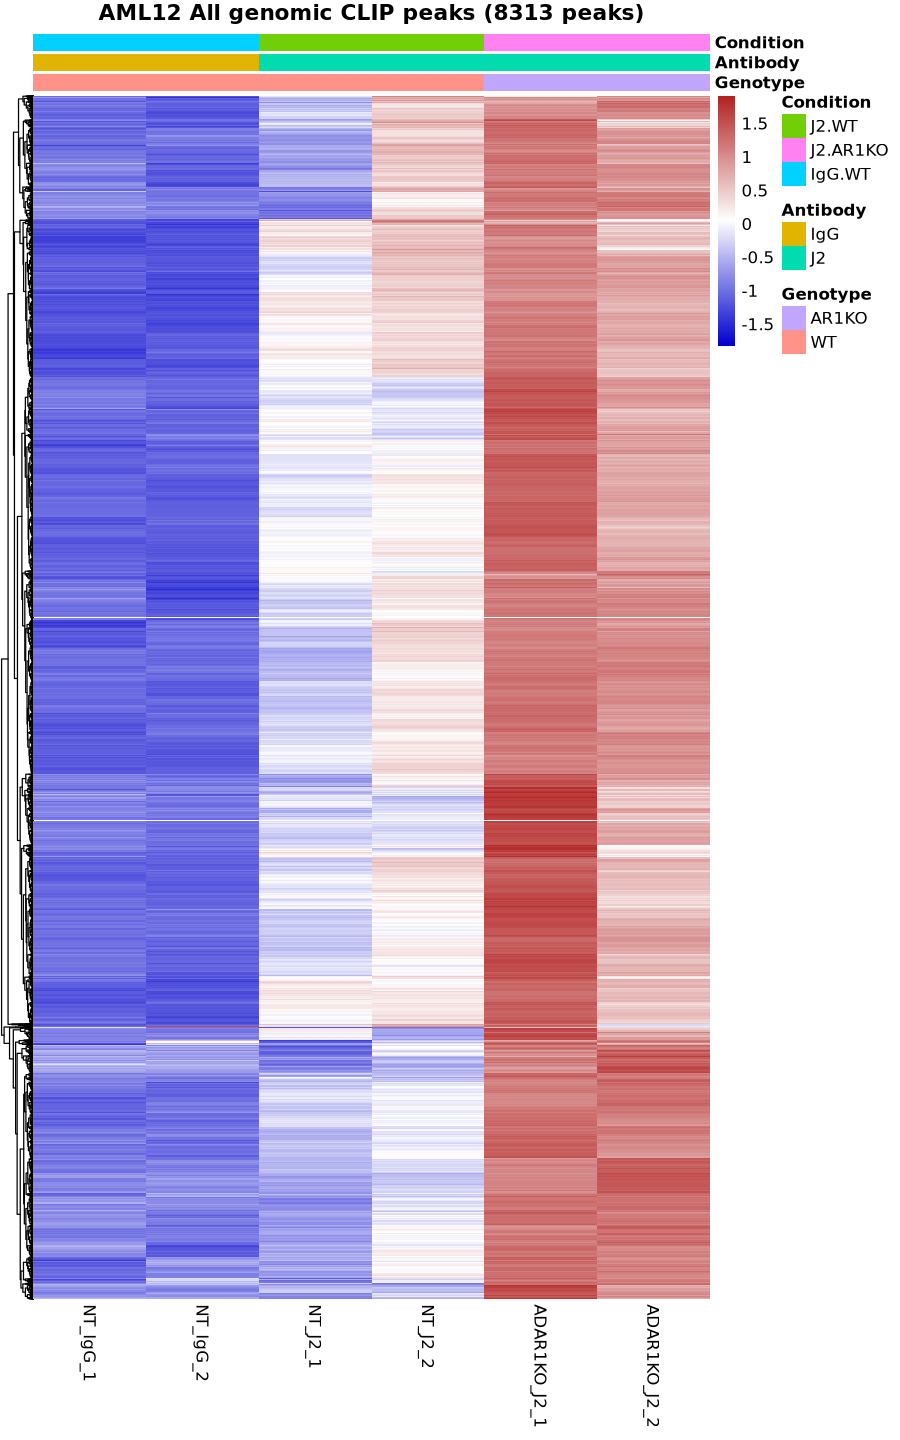

In [21]:
options(repr.plot.width = 7.5,repr.plot.height = 12)

g <- (dds.prior %>% counts(normalized = TRUE))[
    (dds.prior %>% row.names) %in% (
        ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
        filter(Chr != 'chrM') %>% with(Name)
    ),
    coldata %>% 
    mutate(
        Genotype = Genotype %>% factor(levels = c('WT','AR1KO')),
        Antibody = Antibody %>% factor(levels = c('IgG','J2'))
    ) %>% 
    arrange(Pulldown,Genotype) %>% 
    filter(Pulldown == 'eCLIP') %>% 
    row.names
] %>% 
(function(.) log2(.)) %>% 
t %>% scale %>% t %>% 
(function(.) pheatmap(.,main = paste0('AML12 All genomic CLIP peaks (',nrow(.),' peaks)'),#cluster_rows = hclust.all.genomic,
    treeheight_row = 15,
    labels_col = gsub('^AR','ADAR',gsub('WT_','NT_',gsub('count\\.eCLIP_','',coldata %>% 
mutate(
    Genotype = Genotype %>% factor(levels = c('WT','AR1KO')),
    Antibody = Antibody %>% factor(levels = c('IgG','J2'))
) %>% 
arrange(Pulldown,Genotype) %>% 
filter(Pulldown == 'eCLIP' & Genotype != 'AR2KO') %>% 
row.names))),
    border = NA,
    annotation_col = dds.prior@colData %>% data.frame %>% dplyr::select(Genotype,Antibody,Condition),
    cluster_cols = FALSE,
    color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(255),
    show_rownames = FALSE,
    silent = TRUE
)
)

g


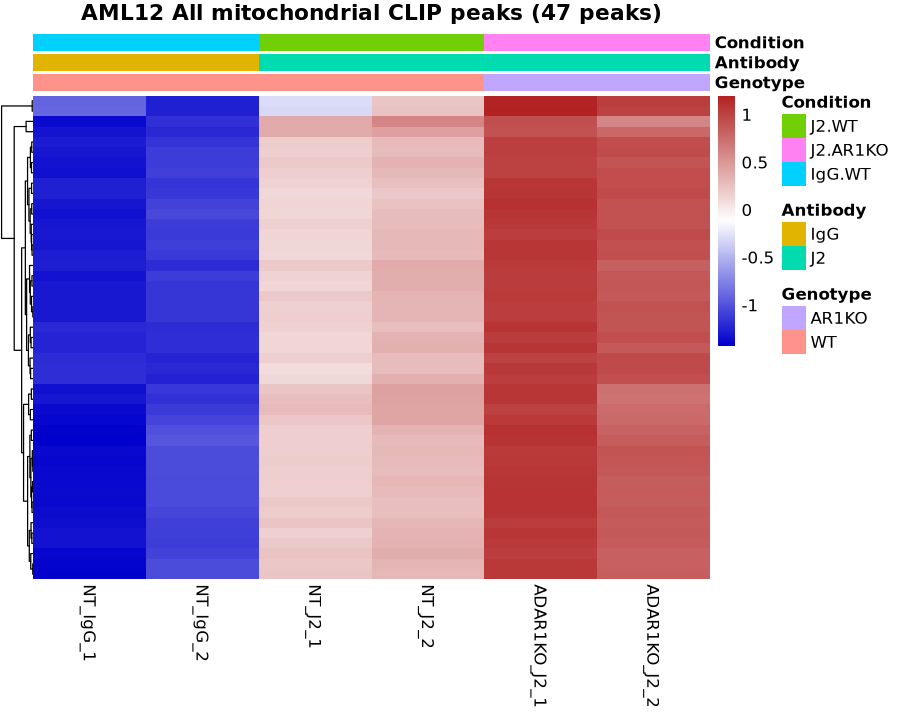

In [22]:
options(repr.plot.width = 7.5,repr.plot.height = 6)

g <- (dds.prior %>% counts(normalized = TRUE))[
    (dds.prior %>% row.names) %in% (
        ddr.subcontrol.eclip.normalisedByInput.nbinomwaldtest.anno %>% 
        filter(Chr == 'chrM') %>% with(Name)
    ),
    coldata %>% 
    mutate(
        Genotype = Genotype %>% factor(levels = c('WT','AR1KO')),
        Antibody = Antibody %>% factor(levels = c('IgG','J2'))
    ) %>% 
    arrange(Pulldown,Genotype) %>% 
    filter(Pulldown == 'eCLIP') %>% 
    row.names
] %>% 
(function(.) log2(.)) %>% 
t %>% scale %>% t %>% 
(function(.) pheatmap(.,main = paste0('AML12 All mitochondrial CLIP peaks (',nrow(.),' peaks)'),#cluster_rows = hclust.all.genomic,
    treeheight_row = 15,
    labels_col = gsub('^AR','ADAR',gsub('WT_','NT_',gsub('count\\.eCLIP_','',coldata %>% 
mutate(
    Genotype = Genotype %>% factor(levels = c('WT','AR1KO')),
    Antibody = Antibody %>% factor(levels = c('IgG','J2'))
) %>% 
arrange(Pulldown,Genotype) %>% 
filter(Pulldown == 'eCLIP' & Genotype != 'AR2KO') %>% 
row.names))),
    border = NA,
    annotation_col = dds.prior@colData %>% data.frame %>% dplyr::select(Genotype,Antibody,Condition),
    cluster_cols = FALSE,
    color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(255),
    show_rownames = FALSE,
    silent = TRUE
)
)

g


In [23]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.4 (Ootpa)

Matrix products: default
BLAS/LAPACK: /home/users/nus/vincent2/micromamba/envs/R4.3-env/lib/libopenblasp-r0.3.26.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Singapore
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggplotify_0.1.2             pheatmap_1.0.12            
 [3] DESeq2_1.42.1               SummarizedExperiment_1.32.0
 [5] Biobase_2.62.0              MatrixGenerics_1.14.0 